In [ ]:
'''
changed loss function in updated QNN circuit with (128x128) and 6 qubits
removed weighted sampler
changing weight decay to 0.005
changed patience - 5
changed optimizer to adam with momentum
quantum layers = 3
gamma = 1.5

*** need to run this model again as saved model was manipulated by other code ***


'''

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from collections import Counter
import numpy as np
import random
import os
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
import pennylane as qml
from pennylane.qnn import TorchLayer
from tqdm.notebook import tqdm

#for loss function 
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Set seeds for reproducibility
def seed_all(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_all(42)

# ========== DEVICE ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== PARAMETERS ==========
n_qubits = 6
batch_size = 16
num_classes = 25
num_epochs = 50
lr = 0.0005

# ========== TRANSFORMS WITH DATA AUGMENTATION ==========
# ✅ For training (with augmentation)
train_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ✅ For validation and test (no augmentation)
eval_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# ========== DATASETS ==========
train_dataset = ImageFolder('/home/netsec1/dataset_folder/malimg_dataset/train', transform=train_transform)
val_dataset   = ImageFolder('/home/netsec1/dataset_folder/malimg_dataset/val', transform=eval_transform)
test_dataset  = ImageFolder('/home/netsec1/dataset_folder/malimg_dataset/test', transform=eval_transform)
print("**dataset loaded**")
# ========== CLASS WEIGHTS ==========
from sklearn.utils.class_weight import compute_class_weight

labels = [label for _, label in train_dataset.samples]
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_wts = torch.tensor(class_weights, dtype=torch.float)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# ========== QUANTUM CIRCUIT ==========
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")

def quantum_circuit(inputs, weights):
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    
    for l in range(weights.shape[0]):
        for i in range(n_qubits):
            qml.RY(weights[l][i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])
    
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (6, n_qubits)}


# ========== CNN + QNN MODEL ==========
class FeatureReduce(nn.Module):
    def __init__(self, final_dim, dropout=0.4):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),    # 128 -> 64
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv2d(8, 16, 3, stride=2, padding=1),   # 64 -> 32
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 32 -> 16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 16 -> 8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # ⬅️ Extra block: 8 -> 4
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))                # 4×4 -> 1×1
        )
        self.fc = nn.Linear(128, final_dim)  # ⬅️ Changed from 64 to 128

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class HybridQNN(nn.Module):
    def __init__(self, n_qubits, num_classes):
        super().__init__()
        self.feature_extractor = FeatureReduce(final_dim=n_qubits)
        self.q_layer = TorchLayer(quantum_circuit, weight_shapes)

        # Adding 4-layer MLP after quantum layer
        self.classifier = nn.Sequential(
            nn.Linear(n_qubits, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.tanh(x)
        q_out = torch.stack([self.q_layer(f) for f in x])
        return self.classifier(q_out)

# ========== TRAINING ==========
print("Starting training")

model = HybridQNN(n_qubits=n_qubits, num_classes=num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.005)
# Convert numpy array to tensor and move to device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
# Now create the loss function
loss_fn = FocalLoss(alpha=1, gamma=1.5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5,
)

def train(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, correct = 0.0, 0
    
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Clip gradients for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
    
    return total_loss / len(dataloader), correct / len(dataloader.dataset)


def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total  # This should never exceed 1.0
    return total_loss / len(dataloader), accuracy

# ========== RUN TRAINING WITH EARLY STOPPING ==========
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Early Stopping variables
early_stopping_patience = 7
best_val_loss = float('inf')
epochs_without_improvement = 0

print("Start training")

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Visualization (bar plot of accuracy per epoch)
    plt.figure(figsize=(8, 4))
    plt.bar(["Train", "Val"], [train_acc, val_acc])
    plt.title(f"Epoch {epoch+1}")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.show()

    # ===== Early Stopping Logic =====
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict() ,"best_model_ch4.pth")
        print("💾 Best model saved.")
    else:
        epochs_without_improvement += 1
        print(f"🕒 No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= early_stopping_patience:
        print(f"⏹️ Early stopping triggered after {epoch+1} epochs.")
        



🔁 Resuming training for 30 more epochs...


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 51 | Train Loss: 0.4278 | Train Acc: 0.7733 | Val Acc: 0.8711


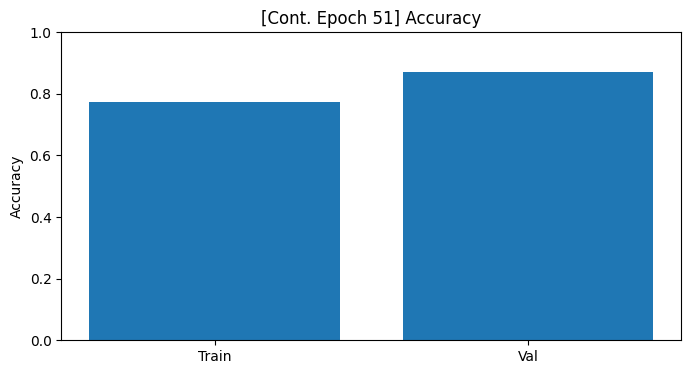

💾 New best model saved (continued training).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 52 | Train Loss: 0.4317 | Train Acc: 0.7753 | Val Acc: 0.8743


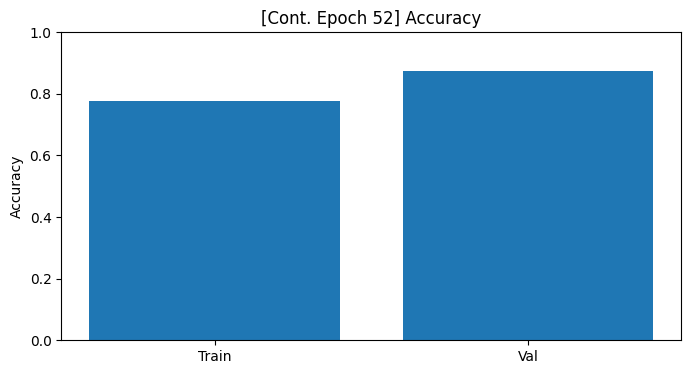

💾 New best model saved (continued training).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 53 | Train Loss: 0.4005 | Train Acc: 0.7840 | Val Acc: 0.8743


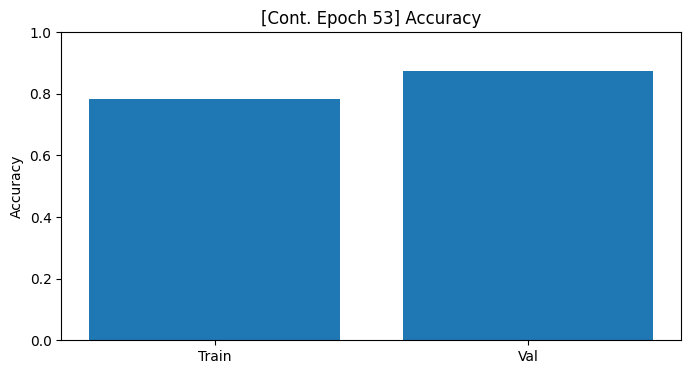

🕒 No improvement for 1 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 54 | Train Loss: 0.3974 | Train Acc: 0.7947 | Val Acc: 0.8776


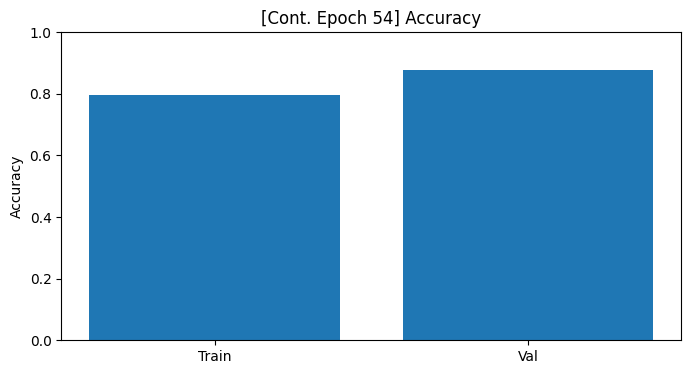

💾 New best model saved (continued training).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 55 | Train Loss: 0.3399 | Train Acc: 0.8005 | Val Acc: 0.8505


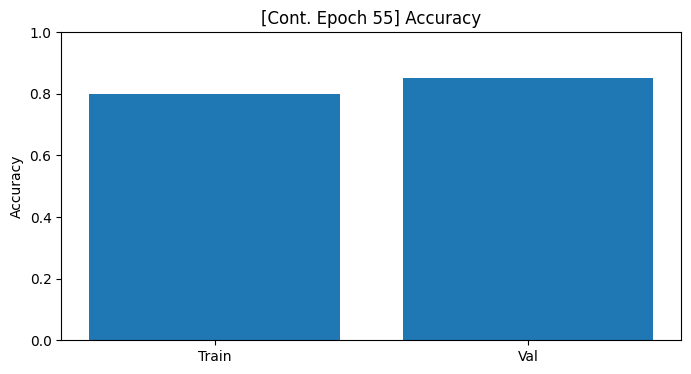

🕒 No improvement for 1 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 56 | Train Loss: 0.3467 | Train Acc: 0.8005 | Val Acc: 0.8862


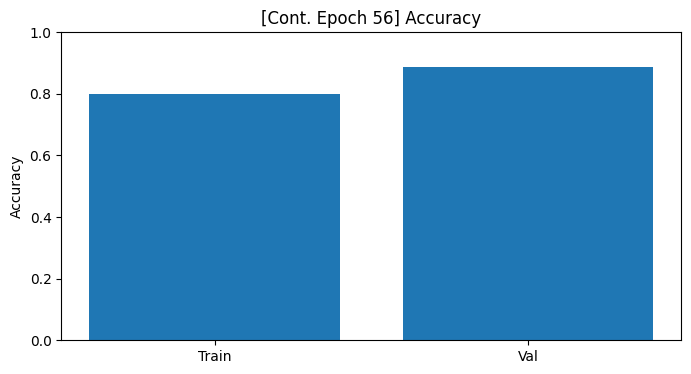

💾 New best model saved (continued training).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 57 | Train Loss: 0.3269 | Train Acc: 0.8134 | Val Acc: 0.8808


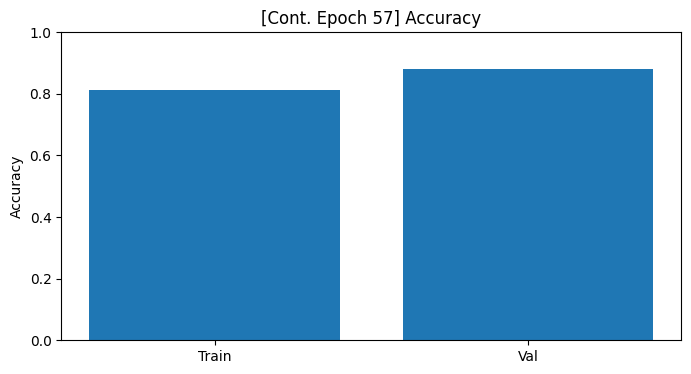

💾 New best model saved (continued training).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 58 | Train Loss: 0.3145 | Train Acc: 0.8135 | Val Acc: 0.9014


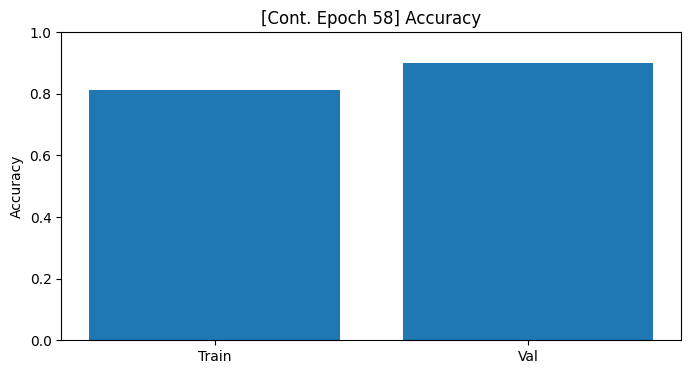

💾 New best model saved (continued training).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 59 | Train Loss: 0.2969 | Train Acc: 0.8195 | Val Acc: 0.8819


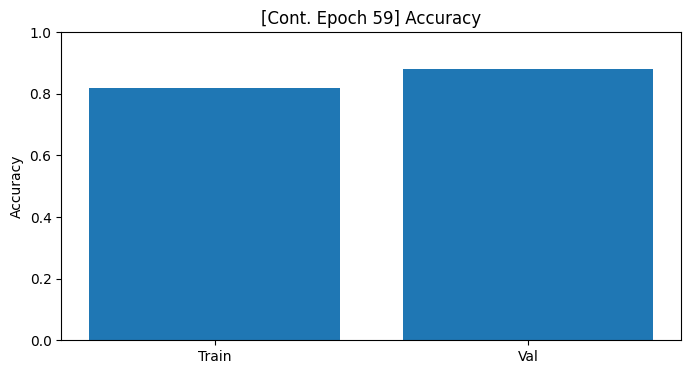

💾 New best model saved (continued training).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 60 | Train Loss: 0.2965 | Train Acc: 0.8269 | Val Acc: 0.8754


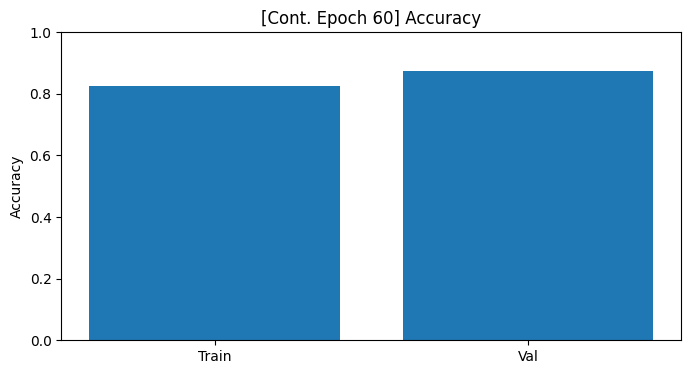

🕒 No improvement for 1 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 61 | Train Loss: 0.2866 | Train Acc: 0.8315 | Val Acc: 0.9209


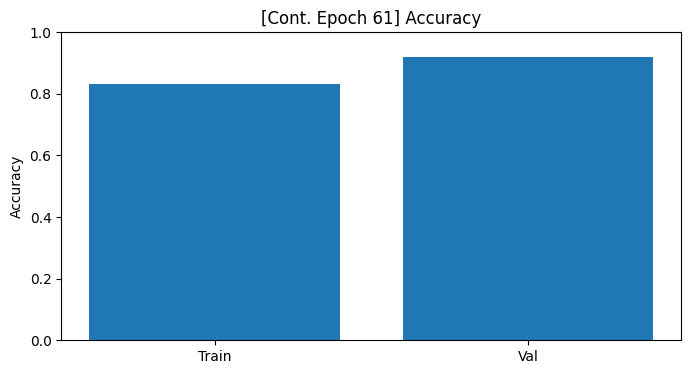

💾 New best model saved (continued training).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 62 | Train Loss: 0.2684 | Train Acc: 0.8358 | Val Acc: 0.9155


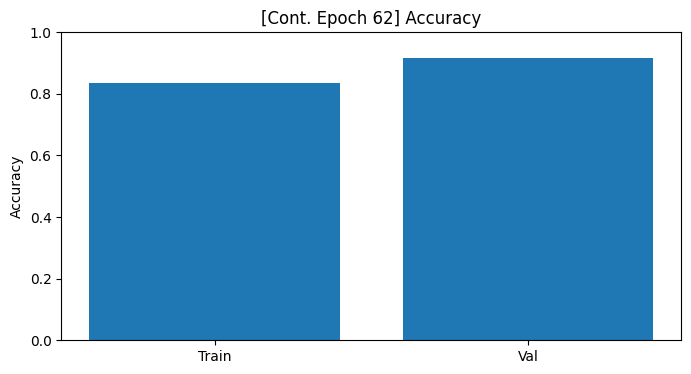

🕒 No improvement for 1 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 63 | Train Loss: 0.2621 | Train Acc: 0.8399 | Val Acc: 0.9047


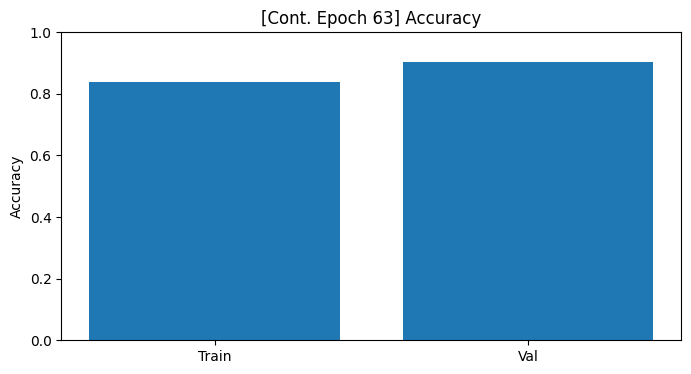

🕒 No improvement for 2 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 64 | Train Loss: 0.2440 | Train Acc: 0.8480 | Val Acc: 0.9014


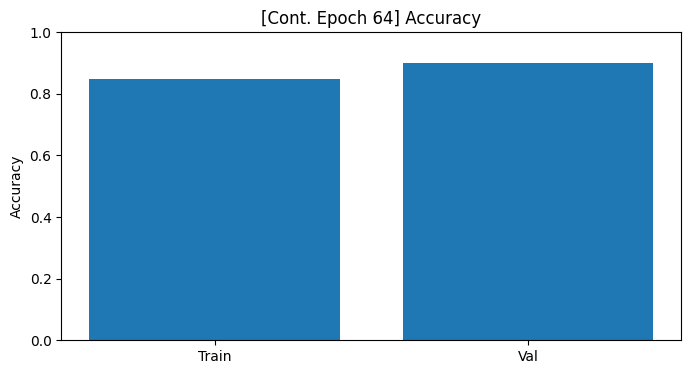

💾 New best model saved (continued training).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 65 | Train Loss: 0.2464 | Train Acc: 0.8477 | Val Acc: 0.9047


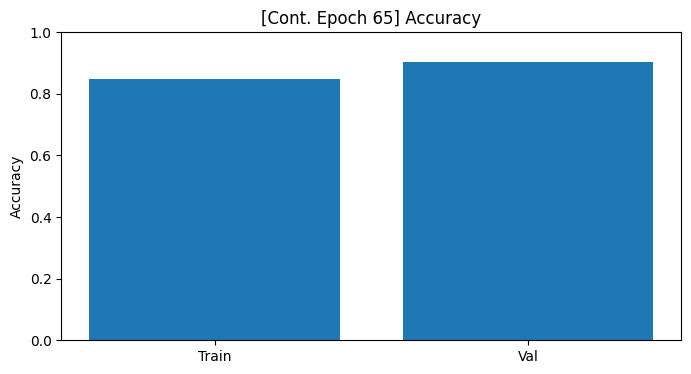

🕒 No improvement for 1 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 66 | Train Loss: 0.2415 | Train Acc: 0.8501 | Val Acc: 0.8917


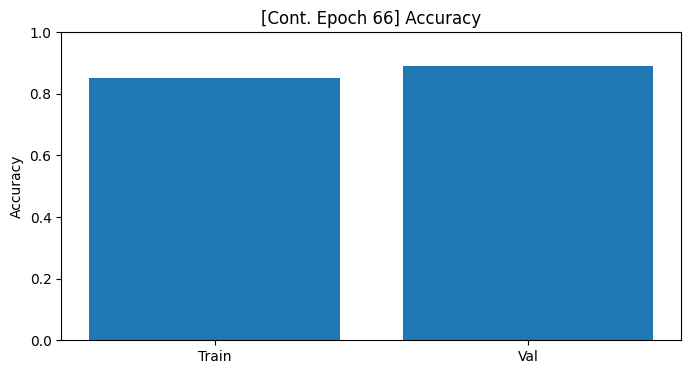

🕒 No improvement for 2 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 67 | Train Loss: 0.2313 | Train Acc: 0.8572 | Val Acc: 0.9003


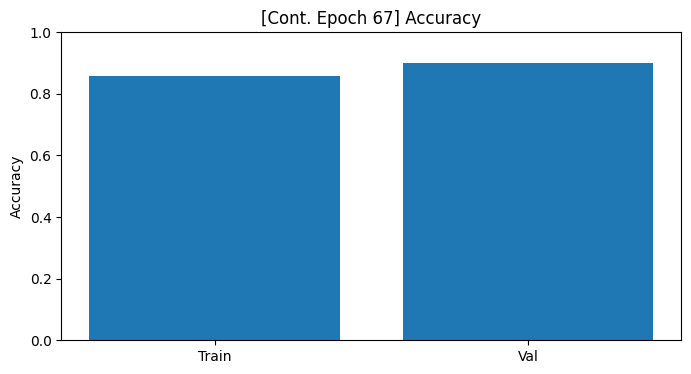

🕒 No improvement for 3 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 68 | Train Loss: 0.2142 | Train Acc: 0.8633 | Val Acc: 0.8949


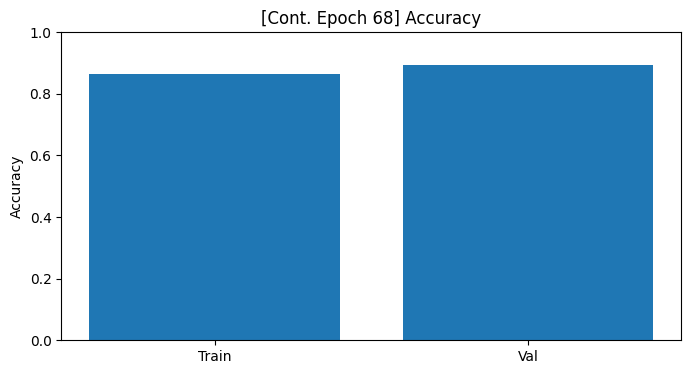

🕒 No improvement for 4 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[CONT] Epoch 74 | Train Loss: 0.2097 | Train Acc: 0.8714 | Val Acc: 0.8895


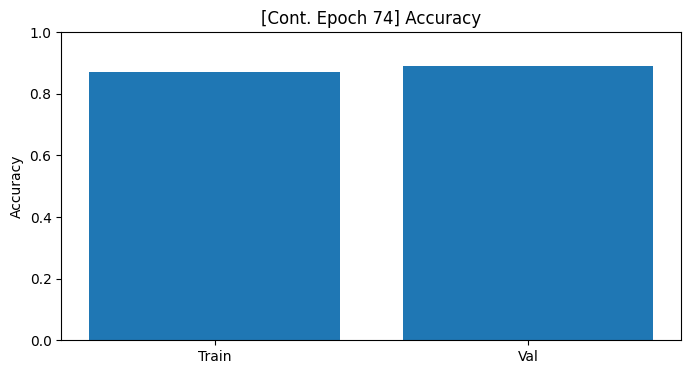

🕒 No improvement for 1 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 75 | Train Loss: 0.1880 | Train Acc: 0.8784 | Val Acc: 0.9307


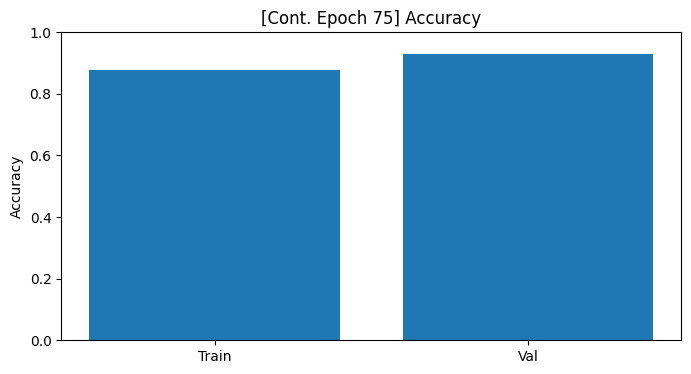

🕒 No improvement for 2 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 76 | Train Loss: 0.1963 | Train Acc: 0.8780 | Val Acc: 0.9404


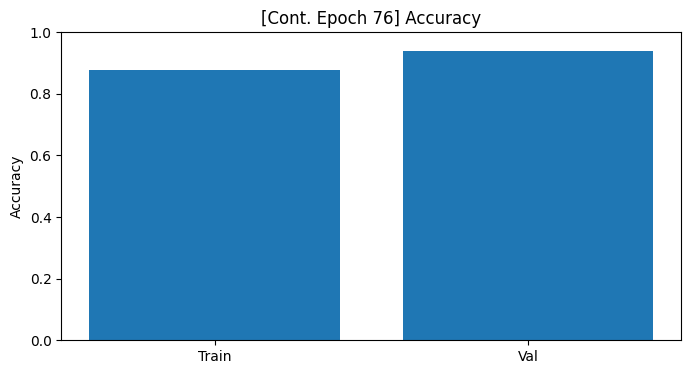

💾 New best model saved (continued training).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 77 | Train Loss: 0.1879 | Train Acc: 0.8793 | Val Acc: 0.9317


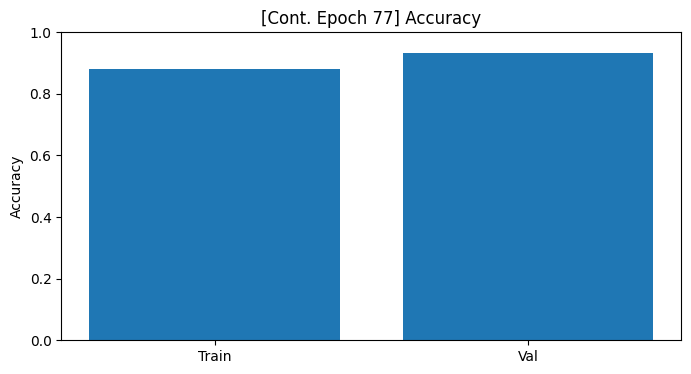

🕒 No improvement for 1 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 78 | Train Loss: 0.3827 | Train Acc: 0.8866 | Val Acc: 0.9350


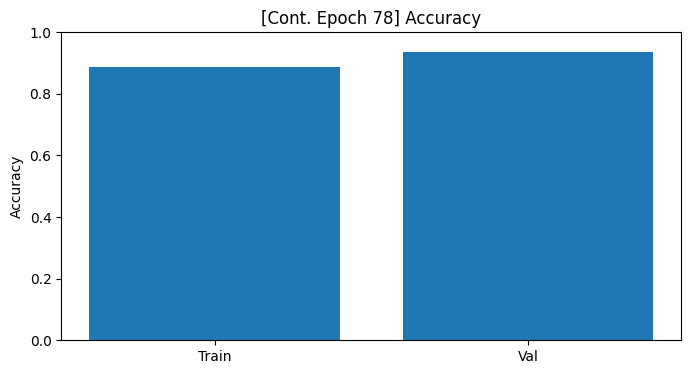

🕒 No improvement for 2 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 79 | Train Loss: 0.2434 | Train Acc: 0.8843 | Val Acc: 0.9404


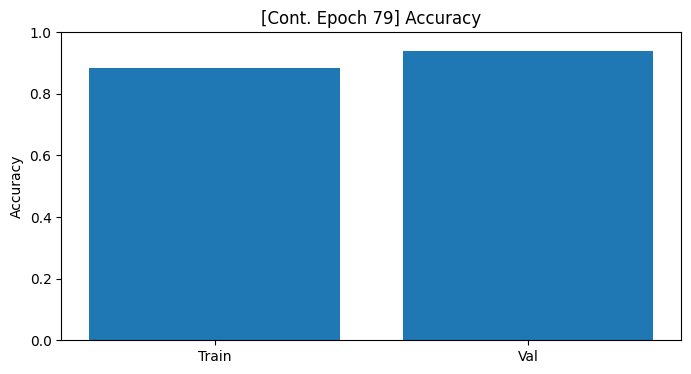

💾 New best model saved (continued training).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 80 | Train Loss: 0.1743 | Train Acc: 0.8858 | Val Acc: 0.9458


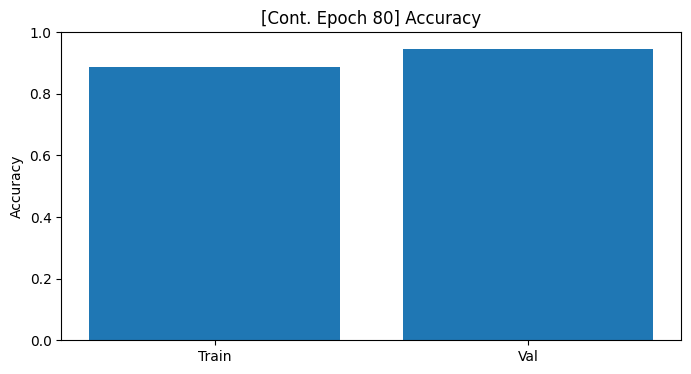

💾 New best model saved (continued training).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 81 | Train Loss: 0.1691 | Train Acc: 0.8934 | Val Acc: 0.9437


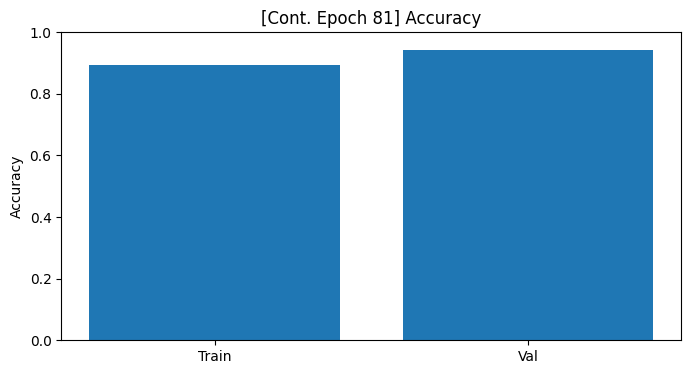

💾 New best model saved (continued training).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 82 | Train Loss: 0.1607 | Train Acc: 0.8997 | Val Acc: 0.9307


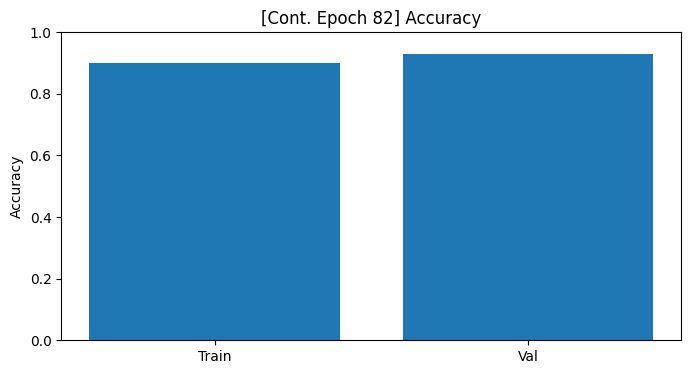

🕒 No improvement for 1 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 83 | Train Loss: 0.1750 | Train Acc: 0.8993 | Val Acc: 0.9599


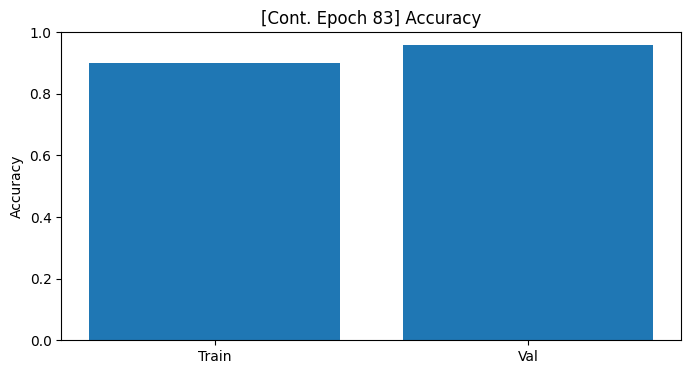

🕒 No improvement for 2 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

[CONT] Epoch 84 | Train Loss: 0.1665 | Train Acc: 0.8982 | Val Acc: 0.9372


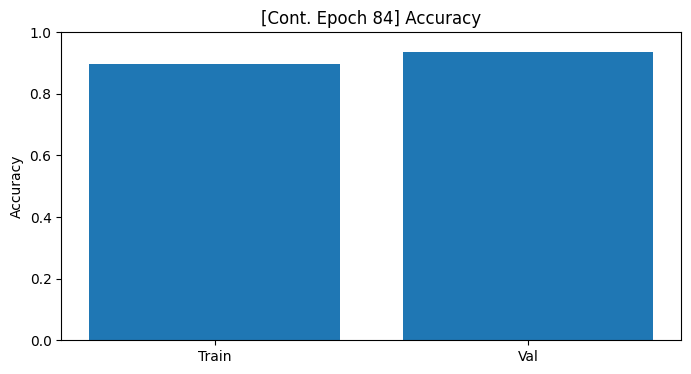

🕒 No improvement for 3 continued epoch(s).


  0%|          | 0/467 [00:00<?, ?it/s]

In [ ]:
# for additional epoch training

# ======== RESUME TRAINING FROM BEST MODEL AFTER 50 EPOCHS ========
print("\n🔁 Resuming training for 30 more epochs...")

early_stopping_patience=5 
# Load the best model saved during the first 50 epochs
model.load_state_dict(torch.load("best_model_ch4.pth"))

def train(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, correct = 0.0, 0
    
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Clip gradients for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
    
    return total_loss / len(dataloader), correct / len(dataloader.dataset)


def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total  # This should never exceed 1.0
    return total_loss / len(dataloader), accuracy
    
# Initialize tracking lists if not loaded from earlier
train_losses, val_losses = [], []
train_accs, val_accs = [], []


# Reset early stopping counter and update number of epochs
epochs_without_improvement = 0
best_val_loss = float('inf')  # Reset to find new best in extended training

# Continue training
extra_epochs = 50
for epoch in range(num_epochs, num_epochs + extra_epochs):
    train_loss, train_acc = train(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    scheduler.step(val_loss)
    
    print(f"[CONT] Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Accuracy visualization
    plt.figure(figsize=(8, 4))
    plt.bar(["Train", "Val"], [train_acc, val_acc])
    plt.title(f"[Cont. Epoch {epoch+1}] Accuracy")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.show()

    # Early Stopping Logic (continued)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model_final_ch4.pth")
        print("💾 New best model saved (continued training).")
    else:
        epochs_without_improvement += 1
        print(f"🕒 No improvement for {epochs_without_improvement} continued epoch(s).")

    if epochs_without_improvement >= early_stopping_patience:
        print(f"⏹️ Early stopping triggered in continued training at epoch {epoch+1}.")


In [4]:
# printing other performance matrix
from sklearn.metrics import classification_report, confusion_matrix
import torch

model = HybridQNN(n_qubits=n_qubits, num_classes=num_classes).to(device)
model.load_state_dict(torch.load("best_model2.pth"))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:  # or val_loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print("done__")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


done__
Classification Report:
                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        14
     Agent.FYI       0.87      1.00      0.93        13
     Allaple.A       1.00      1.00      1.00       296
     Allaple.L       1.00      1.00      1.00       160
 Alueron.gen!J       1.00      0.95      0.98        21
     Autorun.K       0.00      0.00      0.00        12
       C2LOP.P       0.00      0.00      0.00        16
   C2LOP.gen!g       0.56      0.95      0.70        20
Dialplatform.B       1.00      1.00      1.00        20
     Dontovo.A       1.00      0.88      0.94        17
      Fakerean       1.00      0.97      0.99        39
 Instantaccess       0.98      1.00      0.99        44
    Lolyda.AA1       1.00      1.00      1.00        22
    Lolyda.AA2       1.00      1.00      1.00        21
    Lolyda.AA3       1.00      0.92      0.96        13
     Lolyda.AT       1.00      1.00      1.00        17
   Malex.gen!J   

/home/netsec1/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/netsec1/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/netsec1/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 🛠️ Recommendations:

# Augment data for underperforming classes.

# Try class-specific oversampling (or re-enable WeightedRandomSampler).

# Use confusion matrix to see which classes are being confused.

# Continue training (maybe unfreeze earlier layers if you’re using transfer learning).